# Flow visualization

**Goal:** Look the output of different layers of the flow as you take steps transforming from random noise into the target distribution.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
from matplotlib import gridspec
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  

from sklearn.preprocessing import StandardScaler
from scipy.stats import binned_statistic_2d, chisquare
from scipy.stats import norm 
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2
from eventDisplays import rainbow_text
from termcolor import colored

os.sys.path.append('../Flow-Models')
from mdn import MixtureDensityNetwork
from densityEstimate import *
from densityPlots import *

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


**Step 1:** Load in the dataset

In [2]:
prodTag = 'FEB20'
ntag = 2
subDir = 'data16_PFlow-FEB20-5jets'
p = 0.01

tag = f'_SM_2b_p_{p}'
configDir = f'data16_PFlow-FEB20-5jets{tag}_2b_detaCut'
s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'

di = data(5, 16, prodTag,tag,ntag, s)    
mi = (di.df.abs_deta_hh < 1.5)

cols = ['log_m_hh_cor2','absCosThetaStar']
di.mlPrepare(mi, cols, N=-1)

../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 52080 events from 52080 available for the training / validation set


**Step 2:** Load in a trained model

In [3]:
L, H = 5, 16
lr, beta = 0.001, 1e-3

ri = RealNVP(f'{subDir}{tag}_2b_detaCut', lr, beta, cols, 0, L, H,
             load_model=True,modelBaseDir='../Flow-Models/models')

lr = 0.001, weight decay = 0.001, iter = 0, cols = ['log_m_hh_cor2', 'absCosThetaStar']
Setting up a R-NVP model with 5 layers, hidden_dim=16
tensor([0., 1.])


**Step 3:** Transform from random noise through the analysis chain, and just keep training

In [4]:
Xi = di.X_SR

#Xi = torch.ones(10000).reshape(-1,1)*torch.tensor([0,0]).float()

inputs = torch.Tensor(Xi.shape[0], 2).normal_()
preds = [inputs.clone()]

logdets = torch.zeros(inputs.size(0), 1, device=inputs.device)

with torch.no_grad():
    
    for i, module in enumerate(reversed(ri.model._modules.values())):
        inputs, logdet = module(inputs, Xi, 'inverse')
        logdets += logdet
        
        # Add the predictions to the list
        #if i % 2 == 1:
        preds.append(inputs.clone())

In [5]:
len(preds)

11

**Step 4:** Make the nice plot

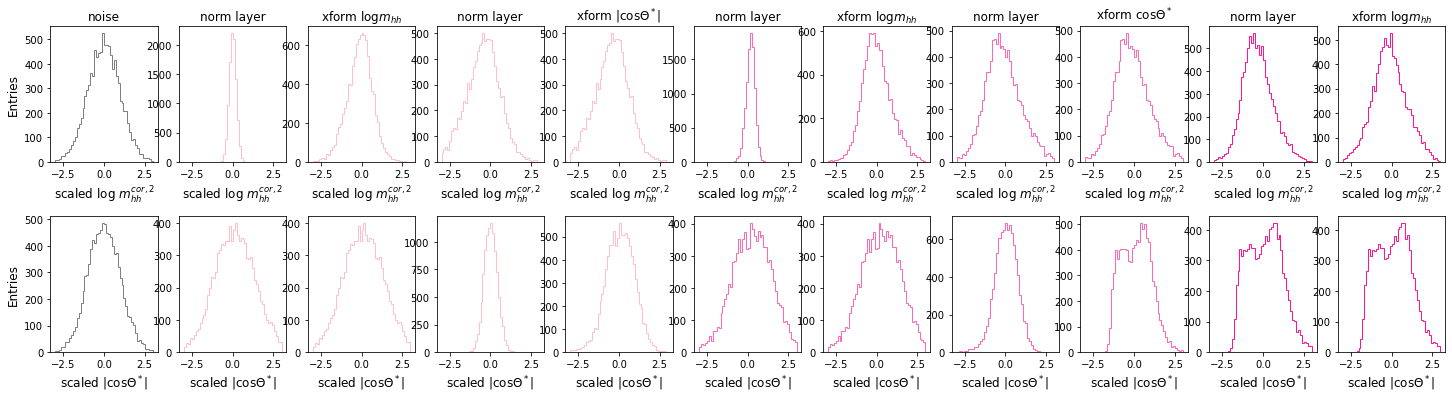

In [6]:
fig, axes = plt.subplots(2,L*2+1,figsize=(25,6),
                         gridspec_kw={'hspace':0.4})

nb = 50
r = (-3,3)

titles = ['noise',
          'norm layer', 'xform $\log m_{hh}$',
          'norm layer', 'xform $|\cos \Theta^*|$',
          'norm layer', 'xform $\log m_{hh}$',
          'norm layer', 'xform $\cos \Theta^*$',
          'norm layer', 'xform $\log m_{hh}$',
         ]

for li, title, pi,c in zip(range(len(preds)),titles,
                           preds,['grey']+['pink']*4+['hotpink']*4+['deeppink']*2):
    
    x,y = pi.numpy().T
    
    axes[0,li].hist(x,nb,r,histtype='step',color=c)
    axes[1,li].hist(y,nb,r,histtype='step',color=c)
    
    # Beautify the plot
    axes[0,li].set_xlabel('scaled $\log \ m_{hh}^{cor,2}$',fontsize=12)
    axes[1,li].set_xlabel('scaled $|\cos \Theta^*|$',fontsize=12)
    
    axes[0,li].set_title(title,fontsize=12)
    
axes[0,0].set_ylabel('Entries',fontsize=12)
axes[1,0].set_ylabel('Entries',fontsize=12)
  
    
#Overlay the 2b pred on the plot   
# Y_np = di.Y_SR.numpy()
# for i in range(2):
#     n_2b,e = np.histogram(Y_np[:,i],nb,r)
#     xx = 0.5 * (e[:-1] + e[1:])
    
#     axes[i,-1].errorbar(xx,n_2b, np.sqrt(n_2b),color='k',linewidth=0,elinewidth=1.5)
    
plt.show()

In [7]:
figDir = 'figures/' + '/'.join(ri.modelDir.split('/')[3:])
figDir

'figures/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut//rnvp_log_m_hh_cor2_absCosThetaStar_5_layers_H_16_lr_0.001_0.001_iter0/'

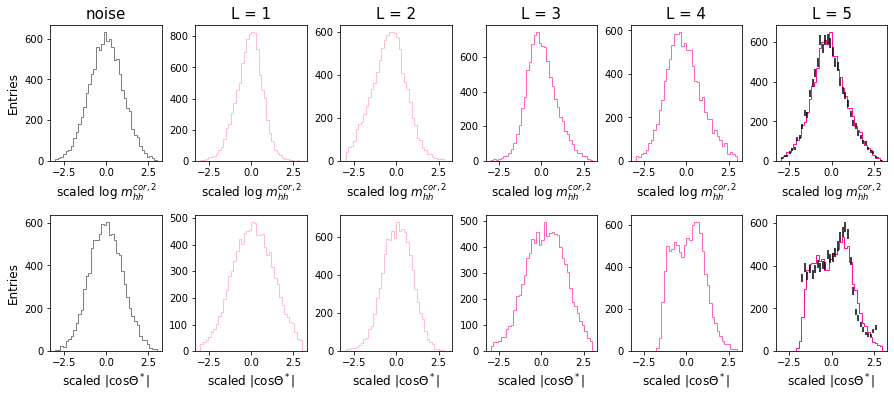

In [8]:
fig, axes = plt.subplots(2,L+1,figsize=(15,6),
                         gridspec_kw={'hspace':0.4,'wspace':0.3})

nb = 40
r = (-3,3)

titles = ['noise'] + [f'L = {i}' for i in range(1,L+1)]

for i, li, title, pi,c in zip(range(L+1),[0,2,4,6,8,10],titles, preds,['grey']+['pink']*2+['hotpink']*2+['deeppink']):
    
    pi = preds[li]
    
    x,y = pi.numpy().T
    
    axes[0,i].hist(x,nb,r,histtype='step',color=c)
    axes[1,i].hist(y,nb,r,histtype='step',color=c)
    
    # Beautify the plot
    axes[0,i].set_xlabel('scaled $\log \ m_{hh}^{cor,2}$',fontsize=12)
    axes[1,i].set_xlabel('scaled $|\cos \Theta^*|$',fontsize=12)
    
    axes[0,i].set_title(title,fontsize=15)
    
axes[0,0].set_ylabel('Entries',fontsize=12)
axes[1,0].set_ylabel('Entries',fontsize=12)
  
plt.savefig(f'{figDir}/viz_flow.pdf',bbox_inches='tight')
    
#Overlay the 2b pred on the plot   
Y_np = di.Y_SR.numpy()
for i in range(2):
    n_2b,e = np.histogram(Y_np[:,i],nb,r)
    xx = 0.5 * (e[:-1] + e[1:])
    
    axes[i,-1].errorbar(xx,n_2b, np.sqrt(n_2b),color='k',linewidth=0,elinewidth=1.5)

plt.savefig(f'{figDir}/viz_flow_2b.pdf',bbox_inches='tight')
    
plt.show()

In [9]:
figDir

'figures/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut//rnvp_log_m_hh_cor2_absCosThetaStar_5_layers_H_16_lr_0.001_0.001_iter0/'

In [10]:
len(preds)

11

In [11]:
# for i in [0,2,4,5]:
#     pi = preds[i]
#     plt.hist(pi.numpy()[:,0],nb,r,histtype='step',label=f'i = {i}')#,ls='--' if i % 2 == 1 else '-')
# plt.legend()
# plt.xlabel('scaled mhh')

# plt.figure()
# for i,pi in enumerate(preds):
#     plt.hist(pi.numpy()[:,1],nb,r,histtype='step')